In [8]:
from PIL import Image
import os
import sys
import torch
import numpy as np
from sklearn.manifold import TSNE
from transformers import CLIPProcessor, CLIPModel
from matplotlib.colors import ListedColormap
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('/data/zhicai/code/Diff-Mix')
from utils import DATASET_NAME_MAPPING

font = {'family': 'serif',
        'weight': 'normal',
        'size': 12,
        }

plt.rc('font', **font)
sys.path.append('/data/zhicai/code/Diff-Mix/')
os.environ["http_proxy"] = "http://localhost:8890"
os.environ["https_proxy"] = "http://localhost:8890"
os.environ["WANDB_DISABLED"] = "true"
device = "cuda:3"




def interpolate_color(color1, color2, weight):
    color1_rgb = np.array([int(color1[i:i+2], 16)
                          for i in (1, 3, 5)])  # Convert hex to RGB
    color2_rgb = np.array([int(color2[i:i+2], 16)
                          for i in (1, 3, 5)])  # Convert hex to RGB
    weight = np.array(weight)  # Convert weight to a NumPy array
    interpolated_rgb = (weight * color1_rgb + (1 - weight) * color2_rgb).astype(int)
    interpolated_hex = "#{:02x}{:02x}{:02x}".format(*interpolated_rgb)
    return interpolated_hex

color1 = '#ff0000'
color2 = '#0000ff'
# weight = 0.5  # You can change the weight as needed
# result = interpolate_color(color1, color2, weight)
# print(result)


## Classification plot (Old)

In [ ]:
strengths = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
plt.plot(strengths, [0.8201,0.8249,0.8293,0.8317,0.8360,0.8324,0.8296,0.8308,0.8290,0.8250], label = 'Diff-Mix (Tuned)')
plt.plot(strengths, [0.8180, 0.8234, 0.8255, 0.8239, 0.8230 , 0.8215, 0.8280, 0.8293, 0.8250,
       0.8250,], label = 'Diff-Aug (Tuned)')
plt.plot(strengths,[0.8187, 0.8261,0.8213,0.8108,0.8072,0.8039,0.8022,0.800,0.800,0.800],label = 'Diff-Aug (Not tuned)')
plt.axhline(y=0.820, color='gray', linestyle='--', label='Baseline')
plt.legend()
plt.show()

## TSNE

In [ ]:
dataset = 'cub'
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
train_ds = DATASET_NAME_MAPPING[dataset](split='train',example_per_class=5)


In [ ]:
source_label = 12
target_label = 99
source_indices = train_ds.label_to_indices[source_label]
target_indices = train_ds.label_to_indices[target_label]

features = []
label_weights = []

for i, idx in enumerate(source_indices):
    img = train_ds.get_image_by_idx(idx)
    features.append(model.get_image_features(
        processor(images=img, return_tensors="pt").pixel_values))
    label_weights.append(1)
    if i == 4:
        break
for i, idx in enumerate(target_indices):
    img = train_ds.get_image_by_idx(idx)
    features.append(model.get_image_features(
        processor(images=img, return_tensors="pt").pixel_values))
    label_weights.append(0)
    if i == 4:
        break
all_features = features 
all_label_weights = label_weights 
# weighted_colors = [interpolate_color(
#     color1, color2, weight) for weight in all_label_weights]
# to_tsne_features = torch.cat(all_features).detach().cpu().numpy()
# img_features = np.array(to_tsne_features)
# tsne = TSNE(n_components=2, perplexity=5, random_state=42)
# img_features_2d = tsne.fit_transform(img_features)

# plt.scatter(img_features_2d[:, 0], img_features_2d[:, 1], c=weighted_colors,cmap=ListedColormap(weighted_colors))
# plt.colorbar(label='Soft Label Intensity')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.title('t-SNE Visualization with Interpolated Colors for Soft Labels')
# plt.show()

### TSNE with cutmix

In [ ]:
import numpy as np
import random
from cutmix.utils import rand_bbox
num_mix = 100
beta = 1.
prob = 1.0

cutmix_features = []
cutmix_label_weights = []

for _ in range(num_mix):
    source_idx = random.choice(source_indices)
    target_idx = random.choice(target_indices)
    r = np.random.rand(1)
    if beta <= 0 or r > prob:
        continue
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    img, img2 = train_ds.get_image_by_idx(
        source_idx), train_ds.get_image_by_idx(target_idx)
    img = processor(images=img, return_tensors="pt").pixel_values
    img2 = processor(images=img2, return_tensors="pt").pixel_values

    bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
    img[:, :, bbx1:bbx2, bby1:bby2] = img2[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) /
               (img.size()[-1] * img.size()[-2]))
    cutmix_label_weights.append(lam)
    cutmix_features.append(model.get_image_features(img))

# all_features = features + cutmix_features
# all_label_weights = label_weights + cutmix_label_weights

# weighted_colors = [interpolate_color(
#     color1, color2, weight) for weight in all_label_weights]
# to_tsne_features = torch.cat(all_features).detach().cpu().numpy()
# img_features = np.array(to_tsne_features)
# tsne = TSNE(n_components=2, perplexity=5, random_state=42)
# img_features_2d = tsne.fit_transform(img_features)

# plt.scatter(img_features_2d[:, 0], img_features_2d[:, 1], c=weighted_colors)
# plt.colorbar(label='Soft Label Intensity')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# # plt.title('t-SNE Visualization with Interpolated Colors for Soft Labels')
# plt.show()

# TSNE with Mixup

In [ ]:
import numpy as np
import random
from cutmix.utils import rand_bbox
num_mix = 100
beta = 1.
prob = 1.0

mixup_features = []
mixup_label_weights = []

for _ in range(num_mix):
    source_idx = random.choice(source_indices)
    target_idx = random.choice(target_indices)
    r = np.random.rand(1)
    if beta <= 0 or r > prob:
        continue
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    img, img2 = train_ds.get_image_by_idx(
        source_idx), train_ds.get_image_by_idx(target_idx)
    img = processor(images=img, return_tensors="pt").pixel_values
    img2 = processor(images=img2, return_tensors="pt").pixel_values



    mixed_x = lam * img + (1 - lam) * img2

    mixup_label_weights.append(lam)
    mixup_features.append(model.get_image_features(mixed_x))

# all_features = features + cutmix_features
# all_label_weights = label_weights + cutmix_label_weights

# weighted_colors = [interpolate_color(
#     color1, color2, weight) for weight in all_label_weights]
# to_tsne_features = torch.cat(all_features).detach().cpu().numpy()
# img_features = np.array(to_tsne_features)
# tsne = TSNE(n_components=2, perplexity=5, random_state=42)
# img_features_2d = tsne.fit_transform(img_features)

# plt.scatter(img_features_2d[:, 0], img_features_2d[:, 1], c=weighted_colors)
# plt.colorbar(label='Soft Label Intensity')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# # plt.title('t-SNE Visualization with Interpolated Colors for Soft Labels')
# plt.show()

### TSNE with diffmix

In [ ]:
from semantic_aug.augmentations.dreabooth_lora import DreamboothLoraMixup
import copy
import random

cub_root_dir = '/data/zhicai/code/Diff-Mix/outputs/aug_samples/cub-db_lora'
DreamboothLoraMixup.pipe=None
db_model = DreamboothLoraMixup(
    model_path = "runwayml/stable-diffusion-v1-5",
    lora_path= "/data/zhicai/code/Diff-Mix/outputs/finetune_model/finetune_ti_db_5shot/sd-cub-model-lora-rank10/pytorch_lora_weights.safetensors",
    embed_path= "/data/zhicai/code/Diff-Mix/outputs/finetune_model/finetune_ti_db_5shot/sd-cub-model-lora-rank10/learned_embeds-steps-last.bin",
    prompt="a photo of a {name}",
    guidance_scale=6,
    mask=0,
    inverted=0,
    device=f'cuda:1'
)

# ti_model = TextualInversionMixup(
#     embed_path='/data/zhicai/code/Diff-Mix/outputs/tokens_merged/cub-tokens/cub-0-16.pt',
#     prompt="a photo of a {name}",
#     guidance_scale=6,
#     mask=0,
#     inverted=0,
#     device=f'cuda:1'
# )

In [9]:
# STRENGTH_LIST = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
num_mix = 100
diffmix_features = []
diffmix_label_weights = []
images_list = []
source_idx = 0

for _ in range(num_mix):
    strength = np.random.beta(1, 1)
    source_idx = random.choice(source_indices)
    target_idx = random.choice(target_indices)
    source_metadata = train_ds.get_metadata_by_idx(source_idx)
    source_image = train_ds.get_image_by_idx(source_idx)
    target_metadata = train_ds.get_metadata_by_idx(target_idx)
    # target_name = target_metadata['name'].replace(" ", "_")
    # source_name = source_metadata['name'].replace(" ", "_")
    try:
        image, _ = db_model(image=[source_image], label=target_label,
                        strength=strength, metadata=target_metadata)
    except:
        pass
    diffmix_features.append(model.get_image_features(
        processor(images=image, return_tensors="pt").pixel_values))
    diffmix_label_weights.append(1 - strength)
    images_list.append(image)

a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <class_99> bird
a photo of a <

In [ ]:
source_idx = random.choice(source_indices)
source_idx

In [ ]:
all_features = features + diffmix_features
all_label_weights = label_weights + diffmix_label_weights

In [10]:
all_features = features + cutmix_features
all_label_weights = label_weights + cutmix_label_weights

In [ ]:
all_features = features + mixup_features
all_label_weights = label_weights + mixup_label_weights

In [27]:
all_features = features + diffmix_features + cutmix_features
all_label_weights = label_weights + diffmix_label_weights+cutmix_label_weights

In [ ]:
len(all_features)

In [ ]:
from utils import visualize_images
images_list = [img.resize((224, 224)) for img in images_list]
visualize_images(images_list, nrow=5, save=False, show=False)

In [ ]:
target_image = train_ds.get_image_by_idx(target_indices[1]).resize((224, 224))
source_image = train_ds.get_image_by_idx(source_idx).resize((224, 224))
visualize_images([source_image, target_image], nrow=2, save=False, show=False)

In [ ]:
len(all_label_weights)

In [ ]:
len(cutmix_features)

## Plot TSNE

In [28]:
weighted_colors = [interpolate_color(
    color1, color2, weight) for weight in all_label_weights]
to_tsne_features = torch.cat(all_features).detach().cpu().numpy()
img_features = np.array(to_tsne_features)
tsne = TSNE(n_components=2, perplexity=5, random_state=43)
img_features_2d = tsne.fit_transform(img_features)



In [ ]:
len(img_features)

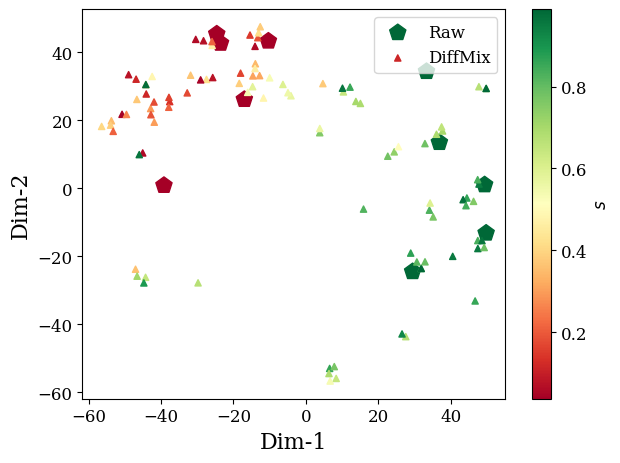

In [37]:
def color_fn(x):
    y = [interpolate_color(
        color1, color2, weight) for weight in x]
    return y
font = {'family': 'serif',
    'weight': 'normal',
    'size': 16,
    }
raw_feat = img_features_2d[:len(features)]
raw_label = all_label_weights[:len(features)]
cutmix_feat = img_features_2d[len(features):len(features)+len(cutmix_features)]
cutmix_label = all_label_weights[len(features):len(features)+len(cutmix_features)]
mixup_feat = img_features_2d[len(features)+len(cutmix_features):len(features)+len(cutmix_features)+len(mixup_features)]
mixup_label = all_label_weights[len(features)+len(cutmix_features):len(features)+len(cutmix_features)+len(mixup_features)]
diffmix_feat = img_features_2d[len(features)+len(cutmix_features)+len(mixup_features):]
diffmix_label = all_label_weights[len(features)+len(cutmix_features)+len(mixup_features):]

plt.scatter(raw_feat[:, 0], raw_feat[:, 1], c=raw_label,marker='p',cmap='RdYlGn',label='Raw',s=150)
plt.scatter(cutmix_feat[:, 0], cutmix_feat[:, 1], c=cutmix_label,marker='^',cmap='RdYlGn',label='DiffMix',s=20)
plt.colorbar(label='$s$')
plt.xlabel('Dim-1',fontdict=font)
plt.ylabel('Dim-2',fontdict=font)
plt.legend(loc='upper right')
# plt.axis('off')
plt.tight_layout()
plt.savefig('../figures/tsne_cub_diffmix.pdf',bbox_inches='tight')

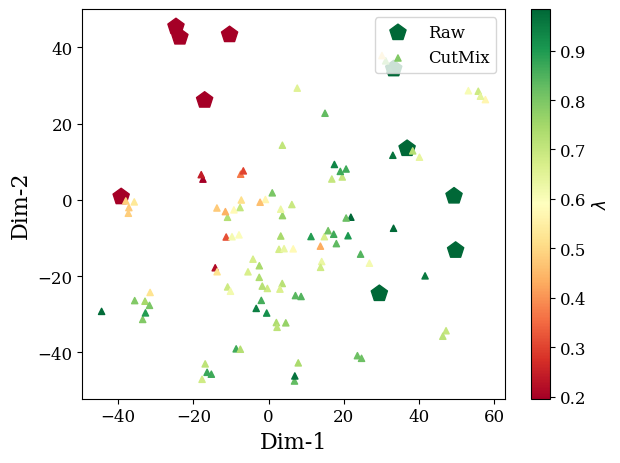

In [34]:
def color_fn(x):
    y = [interpolate_color(
        color1, color2, weight) for weight in x]
    return y
font = {'family': 'serif',
    'weight': 'normal',
    'size': 16,
    }
raw_feat = img_features_2d[:len(features)]
raw_label = all_label_weights[:len(features)]
cutmix_feat = img_features_2d[len(features):len(features)+len(cutmix_features)]
cutmix_label = all_label_weights[len(features):len(features)+len(cutmix_features)]
mixup_feat = img_features_2d[len(features)+len(cutmix_features):len(features)+len(cutmix_features)+len(mixup_features)]
mixup_label = all_label_weights[len(features)+len(cutmix_features):len(features)+len(cutmix_features)+len(mixup_features)]
diffmix_feat = img_features_2d[len(features)+len(cutmix_features)+len(mixup_features):]
diffmix_label = all_label_weights[len(features)+len(cutmix_features)+len(mixup_features):]

plt.scatter(raw_feat[:, 0], raw_feat[:, 1], c=raw_label,marker='p',cmap='RdYlGn',label='Raw',s=150)
plt.scatter(mixup_feat[:, 0], mixup_feat[:, 1], c=mixup_label,marker='^',cmap='RdYlGn',label='CutMix',s=20)
plt.colorbar(label='$\lambda$')
plt.xlabel('Dim-1',fontdict=font)
plt.ylabel('Dim-2',fontdict=font)
# plt.axis('off')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/tsne_cub_cutmix.pdf',bbox_inches='tight')

In [ ]:
plt.scatter(raw_feat[:, 0], raw_feat[:, 1], c=raw_label,marker='p',cmap='viridis',label='Raw',s=100)
plt.scatter(mixup_feat[:, 0], mixup_feat[:, 1], c=mixup_label,marker='^',cmap='viridis',s =20,label='CutMix')
plt.colorbar(label='$\lambda$')
# plt.xlabel('Dim-1',fontdict=font)
# plt.ylabel('Dim-2',fontdict=font)
plt.legend(loc='upper right')
plt.axis('off')
plt.show()
plt.tight_layout()
plt.savefig('../figures/tsne_cub_cutmix.pdf',bbox_inches='tight')

In [ ]:
plt.scatter(raw_feat[:, 0], raw_feat[:, 1], c=raw_label,marker='p',cmap='viridis',label='Raw',s=100)
plt.scatter(diffmix_feat[:, 0], diffmix_feat[:, 1], c=diffmix_label,marker='^',cmap='viridis',s=20,label='Mixup')
plt.colorbar(label='$\lambda$')
plt.xlabel('Dim-1',fontdict=font)
plt.ylabel('Dim-2',fontdict=font)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../figures/tsne_cub_mixup.pdf',bbox_inches='tight')

In [ ]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

to_tsne_features = torch.cat(features).detach().cpu().numpy()
weighted_colors = [interpolate_color(
    color1, color2, weight) for weight in label_weights]
img_features = np.array(to_tsne_features)
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
img_features_2d = tsne.fit_transform(img_features)

# Create a colormap for interpolated colors
# cmap = LinearSegmentedColormap.from_list('Custom Colormap', colors, N=len(set(labels)))

# Plot the t-SNE visualization with interpolated colors based on soft labels
plt.scatter(img_features_2d[:, 0], img_features_2d[:, 1], c=weighted_colors)
plt.colorbar(label='Soft Label Intensity')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization with Interpolated Colors for Soft Labels')
plt.show()

## DATASET basic satistics

In [ ]:
from semantic_aug.datasets.caltech101 import CalTech101Dataset
import matplotlib.pyplot as plt
import numpy as np
caltech101_data_train = CalTech101Dataset(split='train', examples_per_class=-1)
caltech101_data_val = CalTech101Dataset(split='val', examples_per_class=-1)
cls_len_train = [len(images)
                 for images in caltech101_data_train.class_to_images]
cls_len_val = [len(images) for images in caltech101_data_val.class_to_images]
# x轴标签，类别名称
class_names = [f"Class {i}" for i in range(len(cls_len_train))]
plt.figure(figsize=(10, 6))
plt.bar(range(len(cls_len_train)), cls_len_train,
        width=0.4, align='center', label='Train')
plt.bar([i + 0.4 for i in range(len(cls_len_val))], cls_len_val,
        width=0.4, align='center', label='Validation')
plt.legend()

plt.title('Distribution of Images per Class in Caltech101 Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
# 显示图像
plt.show()

## Statistics of classification results

## RealMixup Vs RealAugmentation

In [ ]:

target_dir='outputs/result/main_result_e150'
result_sorted = parse_result(target_dir)

df = result_sorted[(result_sorted['dataset']=='caltech')&(result_sorted['soft power']==0.8)]

baseline = df[(df['strategy']=='baseline')]['acc'].values
realgen = df[(df['strategy']=='realgen')]['acc'].values
realmixup = df[(df['strategy']=='realmixup')]['acc'].values
realaug = df[(df['strategy']=='realaug')]['acc'].values
mixup = df[(df['strategy']=='mixup')]['acc'].values
aug = df[(df['strategy']=='aug')]['acc'].values

# 提取折线图数据和方差数据
realmixup_mean, realmixup_std = realmixup[:, 0], realmixup[:, 1]
realaug_mean, realaug_std = realaug[:, 0], realaug[:, 1]
mixup_mean, mixup_std = mixup[:, 0], mixup[:, 1]
aug_mean, aug_std = aug[:, 0], aug[:, 1]
aug_mean = np.concatenate((aug_mean, [86.28]))
aug_std = np.concatenate((aug_std, [0.0001]))
x = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
plt.figure()

# 绘制带有方差的误差线折线图
plt.errorbar(x, realmixup_mean, yerr=realmixup_std, linestyle='-', marker='*', label='Diff-Mix (Not tuned)')
plt.errorbar(x, mixup_mean, yerr=mixup_std, linestyle='-', marker='o', label='Diff-Mix ')
plt.errorbar(x, realaug_mean, yerr=realaug_std, linestyle='--', marker='*', label='Diff-Aug (Not tuned)')
plt.errorbar(x, aug_mean, yerr=aug_std, linestyle='--', marker='o', label='Diff-Aug')
plt.axhline(y=baseline[:,0], color='gray', linestyle='--', label='Baseline')


# 添加标签和图例
plt.xlabel('Augmentation Strength')
plt.ylabel('Acc.(%)')
plt.legend(loc='upper left')

plt.show()

In [ ]:
[81.567,81.70,81.58,81.60,81.97,81.76]
[81.29,80.79,81.73,82.37,82.28,82.52]

## Main result

In [ ]:
import sys
sys.path.append('/data/zhicai/code/Diff-Mix/')
from utils import parse_result
target_dir = '/data/zhicai/code/Diff-Mix/outputs/result/main_ab_sythetic_probability'
result = parse_result(target_dir, extra_column=['syn_p'])
result

In [ ]:
target_dir = '/data/zhicai/code/Diff-Mix/outputs/result/main_ab_synthetic_size'
parse_result(target_dir, extra_column=['syn_type'])

In [ ]:
target_dir = '/data/zhicai/code/Diff-Mix/outputs/result/main_ab_power'
parse_result(target_dir, extra_column=['syn_type'])

In [ ]:
target_dir = '/data/zhicai/code/Diff-Mix/outputs/result/main_ab_finetune_strategy'
parse_result(target_dir, extra_column=['syn_type'])

In [ ]:
target_dir = '/data/zhicai/code/Diff-Mix/outputs/result/main_ab_finetune_steps'
parse_result(target_dir, extra_column=['syn_type'])

In [ ]:
target_dir = '/data/zhicai/code/Diff-Mix/outputs/result/main_ab_cutmix_mixup'
parse_result(target_dir, extra_column=['use_cutmix','use_mixup','mixup_probability'])

## Annotation strategy, soft power

In [ ]:
import torch
pt = torch.load('/data/zhicai/code/Diff-Mix/cub_train_features.pt')

In [ ]:
import re
import os
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import pandas as pd
import shutil

output_path = '/data/zhicai/code/Diff-Mix/outputs/aug_samples/cub/dreambooth-lora-mixup-Multi7-db_ti35000-Strength0.5'
rootdir = os.path.join(output_path,'data')
# 正则表达式模式来匹配路径中的各个部分
pattern_level_1 = r"(.+)"
pattern_level_2 = r"(.+)-(\d+)-(.+).png"

# Generate meta.csv for indexing images
data_dict = defaultdict(list)
for dir in os.listdir(rootdir):
    if not os.path.isdir(os.path.join(rootdir, dir)):
        continue
    match_1 = re.match(pattern_level_1, dir)
    first_dir = match_1.group(1).replace("_", " ") 
    for file in os.listdir(os.path.join(rootdir, dir)):
        match_2 = re.match(pattern_level_2, file)
        second_dir = match_2.group(1).replace("_", " ")
        num = int(match_2.group(2))
        floating_num = float(match_2.group(3))
        if floating_num != 0.5:
            # delete files with strength not 0.5
            os.remove(os.path.join(rootdir, dir, file))
            continue
        data_dict['First Directory'].append(first_dir)
        data_dict['Second Directory'].append(second_dir)
        data_dict['Number'].append(num)
        data_dict['Strength'].append(floating_num)
        data_dict['Path'].append(os.path.join(dir, file))

df = pd.DataFrame(data_dict)

# Validate generated images
valid_rows = []
for index, row in tqdm(df.iterrows(), total=len(df)):
    image_path = os.path.join(output_path,'data',row['Path'])
    try:
        # 尝试加载图片
        img = Image.open(image_path)
        img.close()  
        valid_rows.append(row)  # 如果成功加载图片，则保留该行
    except Exception as e:
        # 如果加载图片时出错，删除该图片文件
        os.remove(image_path)
        print(f"Deleted {image_path} due to error: {str(e)}")

valid_df = pd.DataFrame(valid_rows)
csv_path = os.path.join(output_path, 'meta.csv')
valid_df.to_csv(csv_path, index=False)

print("DataFrame:")
print(df)

In [ ]:
len(X)